In [1]:
from typing import TypedDict, List, Union
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END

C:\Users\BhaskerSriHarsha\Documents\Environments\pyTorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create the agent space

In [2]:
class AgentState(TypedDict):
    user_query: str
    model_selected: str
    messages : List[Union[HumanMessage, AIMessage]]

### Create the LLMs

In [15]:
mini_llm = ChatOpenAI(model="gpt-4.1-mini")
big_llm = ChatOpenAI(model="o3")

### Create the nodes

In [10]:
def model_selector(state: AgentState) -> AgentState:
    user_query = state["user_query"]
    system_prompt = """
You are a helpful AI that classifies a user query as being <NORMAL> or <MATH>.
If the user query is related to general conversation, output <NORMAL>.
If the user query is related to a math question, output <MATH>.
Do not output any extra text, only output <NORMAL> or <MATH>"""

    llm_messages = [SystemMessage(content=system_prompt), HumanMessage(content=user_query)]
    response = mini_llm.invoke(llm_messages)

    mini_llm_response = response.content
    print(f"[LOG] Model selector: {mini_llm_response}")
    state["model_selected"] = mini_llm_response

    return state

In [11]:
def normal_node(state: AgentState) -> AgentState:
    chatHistory = state["messages"]
    system_prompt = """You are a helpful AI that answers a user query."""
    print(f"[LOG] Normal LLM triggered.")

    llm_messages = [SystemMessage(content=system_prompt)]+chatHistory
    response = mini_llm.invoke(llm_messages)

    mini_llm_response = response.content
    state["messages"] = state["messages"] + [AIMessage(content=mini_llm_response)]
    # print(f"Normal mode: {state['messages']}")

    return state

def math_node(state: AgentState) -> AgentState:
    chatHistory = state["messages"]
    system_prompt = """You are a helpful AI mathematician that answers a user query."""
    print(f"[LOG] Math LLM triggered.")

    llm_messages = [SystemMessage(content=system_prompt)]+chatHistory
    response = big_llm.invoke(llm_messages)

    big_llm_response = response.content
    state["messages"] = state["messages"] + [AIMessage(content=big_llm_response)]

    return state

In [12]:
def switch_node(state: AgentState) -> str:
    selected_model = state["model_selected"]

    if selected_model == "<NORMAL>":
        return "normal_model_selected"
    elif selected_model == "<MATH>":
        return "math_model_selected"

### Create the graph

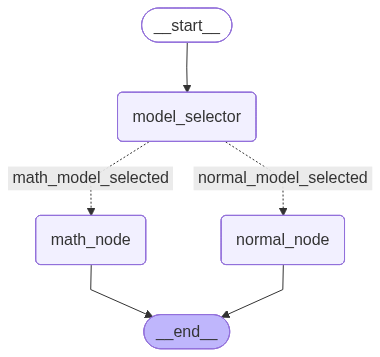

In [13]:
graph = StateGraph(AgentState)

graph.add_node("model_selector", model_selector)
graph.add_node("normal_node", normal_node)
graph.add_node("math_node", math_node)

graph.add_edge(START, "model_selector")
graph.add_conditional_edges(
    "model_selector",
    switch_node,
    {
        "normal_model_selected":"normal_node",
        "math_model_selected":"math_node"
    }
)
graph.add_edge("normal_node", END)
graph.add_edge("math_node", END)

app = graph.compile()
app

### Talk to the graph

In [16]:
conversation_history = []
user_input = input("\n\nHuman: ")

while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))
    final_state = app.invoke({"user_query":user_input, "messages":conversation_history})
    print(final_state['messages'][-1].content)
    user_input = input("\n\nHuman: ")
    conversation_history = final_state['messages']



Human:  what is the root of 312


[LOG] Model selector: <MATH>
[LOG] Math LLM triggered.
If you mean the square root of 312:

Exact radical form
√312 = √(4 × 78) = 2 √78

Decimal approximation
√312 ≈ 17.663521732 …

(If instead you needed another root—such as the cube root—just let me know.)




Human:  what is the root of all evil


[LOG] Model selector: <NORMAL>
[LOG] Normal LLM triggered.
The phrase "the root of all evil" is often used metaphorically. Commonly, it comes from a misquotation of a biblical verse that states "the love of money is the root of all evil" (1 Timothy 6:10). So, in that context, it's saying that greed or excessive desire for money is the cause of many problems or evil actions.

If you meant this phrase in a different or more literal sense, please let me know!




Human:  exit
